# [IAPR 2019:][iapr2019] Lab 2 ‒  Object description

**Author:** first name and last name  
**Due date:** 19.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Description
In the `lab-02-data/` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from **each of those images**, a **2-dimensional feature vector** (i.e. **2 features**) and to plot them all **on a 2D graph**.
If you have chosen good features, the vectors of the "0"'s should **nicely cluster**I  in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. **with and without invariance to rotation, translation, scaling, etc**.
You can also for instance **rotate the images** and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be **constructed by following the contour point after point**.
Some **pre-processing (image binarization, possibly some Mathematical Morphology)** might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

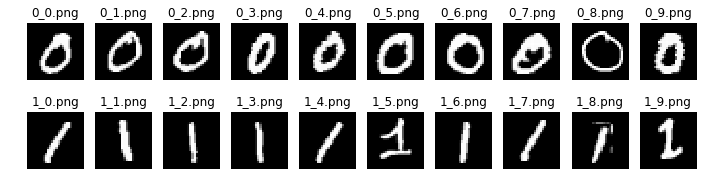

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [3]:
def findContour(im, threshold):
    '''
        Find contour of handwriting number.
    '''
    # Threshold extracting
    im = im > threshold
    label_img = skimage.measure.label(im>0)
    
    # Region growing and get the largest region
    regions=skimage.measure.regionprops(label_img)
    areas = np.array([region.area for region in regions])
    sort_list = np.argsort(areas)[::-1]
    
    # Set the largest region to value '1', others 0
    temp = np.full_like(label_img, False)
    for coord in regions[sort_list[0]].coords:
        temp[coord[0]][coord[1]]=True
    im = temp
    
    # Find the contour of largest region
    contours = find_contours(im, level)
    contour = contours[0]
    
    return contour

- Fourier descriptors for **origin image classification**

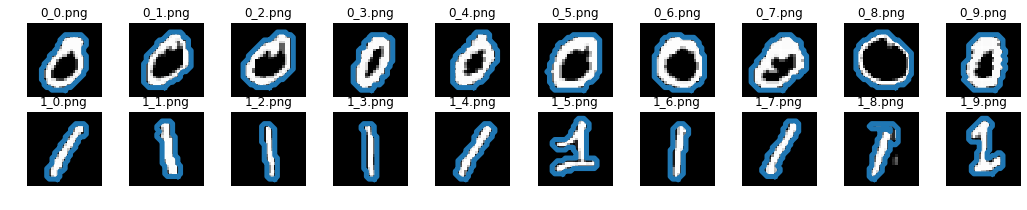

In [4]:
import numpy as np
import skimage.transform as transform
from skimage.measure import find_contours

level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

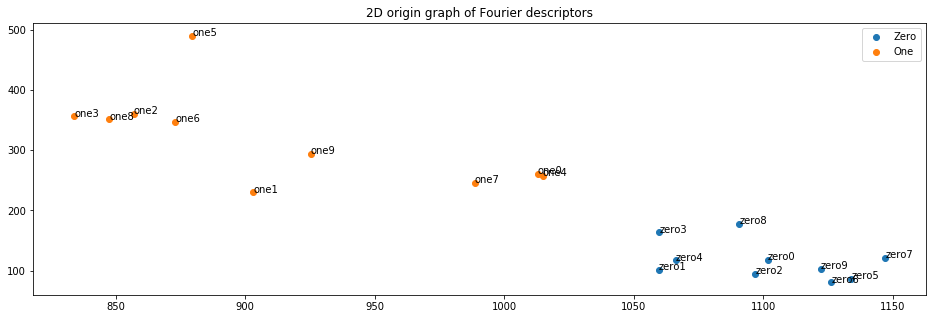

In [5]:
def visFourier(contours_0, contours_1, max_freq=150, text='Origin', component_1=1, component_2=2):
    '''
        contours_0: Contour list of zero images
        contours_1: Contour list of zero images
        max_freq: The frequecy of fourier transformation
        component_1, component_2: Two components of Fourier desciptors used for classfication.
    '''
    # Fourier transformation for images
    zeros_dft, ones_dft = [], []
    zeros_mag, ones_mag = [], []

    # Set the freqency for the Fourier transformation
    for zero, one in zip(contours_0, contours_1):
        zero = [np.complex(cord[0], cord[1]) for cord in zero]
        zero_dft = np.fft.fft(zero, n=max_freq)
        zeros_dft.append(zero_dft)
        zeros_mag.append((np.abs(zero_dft[component_1]), np.abs(zero_dft[component_2])))

        one = [np.complex(cord[0], cord[1]) for cord in one]
        one_dft = np.fft.fft(one, n=max_freq)
        ones_dft.append(one_dft)
        ones_mag.append((np.abs(one_dft[component_1]), np.abs(one_dft[component_2])))

    # Visualize the first two components of Fourier descriptors
    plt.figure(figsize=(16, 5))
    plt.scatter([cord[0] for cord in zeros_mag], [cord[1] for cord in zeros_mag], label='Zero')
    plt.scatter([cord[0] for cord in ones_mag], [cord[1] for cord in ones_mag], label='One')
    plt.legend()
    plt.title("2D " + text + " graph of Fourier descriptors")
    for i, (zero, one) in enumerate(zip(zeros_mag, ones_mag)):
        plt.annotate('zero'+str(i), (zero[0], zero[1]), )
        plt.annotate('one'+str(i), (one[0], one[1]))
    plt.show()

visFourier(contours_0, contours_1, 150, 'origin')

- Fourier descriptors for **rotated image classification**

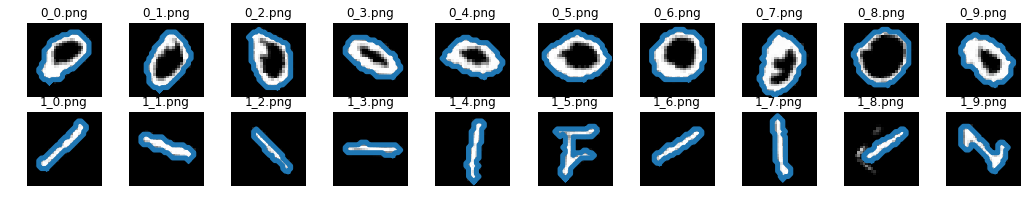

In [6]:
# Randomly rotate images 
import random

level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    degrees = random.randint(0, 180)
    im = transform.rotate(im, degrees)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    degrees = random.randint(0, 180)
    im = transform.rotate(im, degrees)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

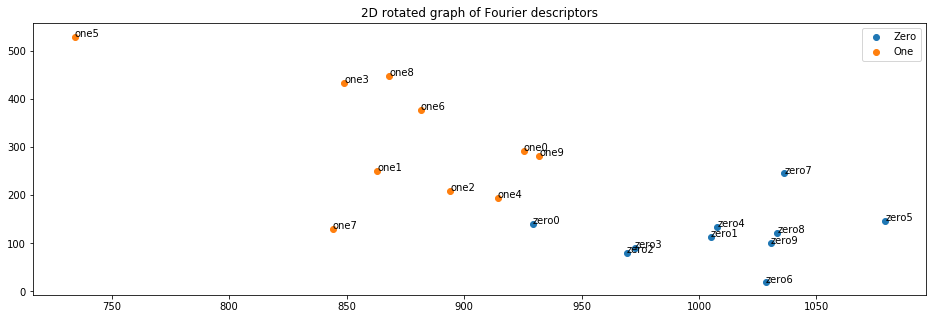

In [7]:
visFourier(contours_0, contours_1, 150, 'rotated')

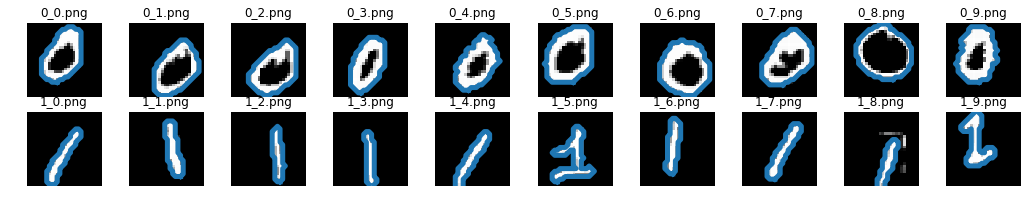

In [8]:
# Randomly translate images, but always keep numbers in sight to maintain the shape infomation
import random

level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    transx = random.randint(-3, 3)
    transy = random.randint(-3, 3)
    tform = transform.SimilarityTransform(translation=(transx, transy))
    im = transform.warp(im, tform)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    transx = random.randint(-3, 3)
    transy = random.randint(-3, 3)
    tform = transform.SimilarityTransform(translation=(transx, transy))
    im = transform.warp(im, tform)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

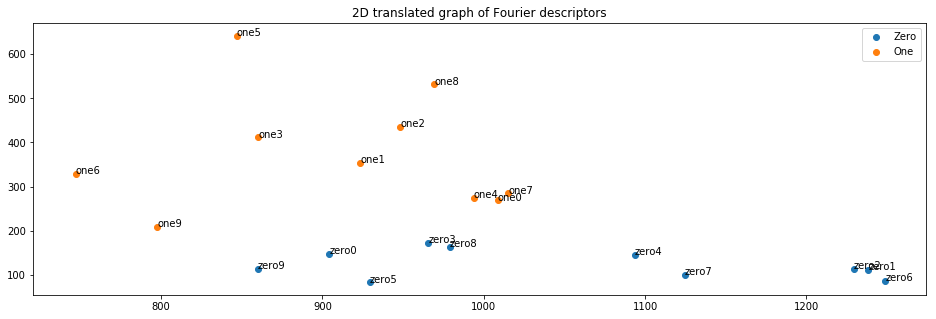

In [9]:
visFourier(contours_0, contours_1, 150, 'translated')

- Scale images for **two times**

c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


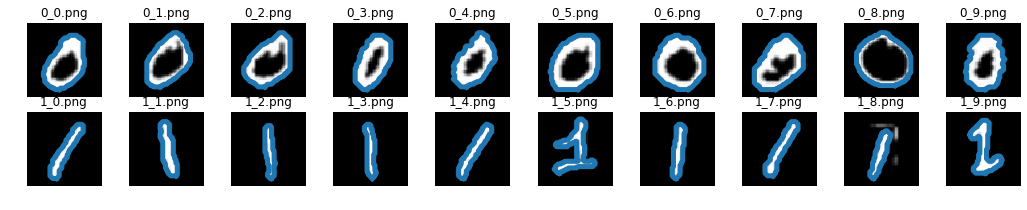

In [10]:
# Here we just zoom in with a magnifing ratio between 1 and 10, since zoom out may cause contour extraction problems
level = 0.01
fig, axes = plt.subplots(2, len(zeros_im), figsize=(18, 3))
contours_0, contours_1 = [], []
scale = 2

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    im = transform.rescale(im, scale)
    contour = findContour(im, 0.5)
    contours_0.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

for ax, im, nm in zip(axes[1], ones_im, ones_names):
    im = transform.rescale(im, scale)
    contour = findContour(im, 0.5)
    contours_1.append(contour)
    
    ax.plot(contour[:, 1], contour[:, 0], linewidth=5)
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

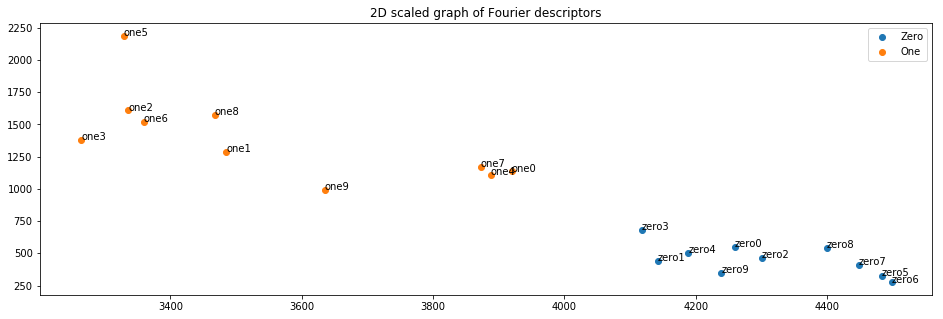

In [11]:
visFourier(contours_0, contours_1, scale*150, 'scaled')

#### Conclusion:
- From 2D graph of Fourier descriptors of **orginal images**, we can see that if we tune a good parameter of **Fourier transform frequency**, two classes of images can be seperated well.
- From 2D graph of Fourier descriptors of **rotated images**, with the same parameter(**Fourier transform frequency**), we find that the images become not as well separatable as orginal images, especially for the **5th** and **9th** images of ones. However, this result is reasonable since we can see that the **5th** and **9th** ones are actually in a different writing way compared with others.
- Similarly, in 2D graph of Fourier descriptors of **scaled images**, **5th** and **9th** ones are not well separatable for the same reason as above. 
- For 2D graph of Fourier descriptors of **translated images**, as long as we keep the all pixels of the numbers in the images(keep the shape infomation), the two classes are separatable. However, both two classes(cluster) have a large variation (nodes are not very concentrated).

### 1.3 Additional method(s)
Add your implementation and discussion

## PCA

In [12]:
from sklearn.decomposition import PCA
def PCA2d(x):
    # The shape of x should be (num_samples, num_features)
    pca = PCA(n_components=2)
    pca.fit(x)
    feature = pca.transform(x)
    return feature

We flatten images pixels into vectors and use PCA to extract the two-dimensional  features. PCA will calculate the covariance matrix and get the eigenvector corresponding to the first two largest eigenvalues. The two eigenvectors can be used for affine tranform to project the high dimensional data to the two-dimensional space. The result is shown below. The data can be divided into two clusters.

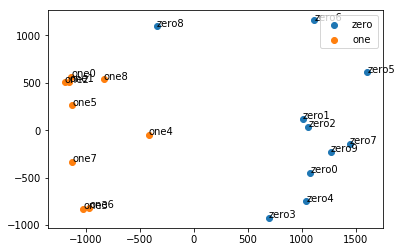

In [13]:
all_ims = np.concatenate((zeros_im, ones_im), 0).reshape((20,-1))
feature = PCA2d(all_ims)
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))

We randomly choose a degree to rotate and rescale the image. Then we use PCA to get the 2-dimensional feature. The plot is very similar to the one above, but the scales of both axis have changed. Therefore, PCA can be resistant to affine transform to the original data.

c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\67009\appdata\local\programs\python\python36\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


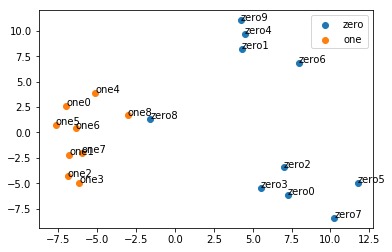

In [14]:
ims_t =[]
for im in np.concatenate((zeros_im, ones_im), 0):
    deg = np.random.randint(0,180)
    im = skimage.transform.rotate(im, deg)
    im = skimage.transform.rescale(im, 2)
    ims_t.append(im[np.newaxis, :, :])
ims_t = np.concatenate(ims_t, 0)
ims_t = ims_t.reshape((20,-1))
feature = PCA2d(ims_t)
plt.scatter(feature[:10, 0], feature[:10, 1],label='zero')
plt.scatter(feature[11:, 0], feature[11:, 1],label='one')
plt.legend()

for i, (zero) in enumerate(feature[:10]):
    plt.annotate('zero'+str(i), (zero[0], zero[1]))
for i, (one) in enumerate(feature[11:]):
    plt.annotate('one'+str(i), (one[0], one[1]))